In [9]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
df = pd.read_csv("/content/spam_ham_dataset.csv")

In [11]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [13]:
df.drop(df.columns[[0, 1]], axis=1, inplace=True)

In [14]:
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [15]:
cols = df.columns.tolist()
cols[0], cols[1] = cols[1], cols[0]
df = df.reindex(columns=cols)

In [16]:
df.head()

,label_num,text
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


In [19]:
df['label_num'] = df['label_num'].astype('category')

In [20]:
df.rename(columns={'label_num': 'target', 'text': 'text'}, inplace=True)

In [21]:
df.head()


,target,text
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


In [22]:
# Check for missing values
print(df.isnull().sum())

# Check for duplicate values
print(df.duplicated().sum())

# Remove duplicate values
df = df.drop_duplicates(keep='first')

target    0
text      0
dtype: int64
178


In [23]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

<ipython-input-23-4720c9f32557>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(len)
<ipython-input-23-4720c9f32557>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
<ipython-input-23-4720c9f32557>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [24]:
# Function to preprocess text
from nltk.stem.porter import PorterStemmer
import string

ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = [i for i in text if i.isalnum()]
    text = y[:]
    y.clear()
    y = [i for i in text if i not in stopwords.words('english') and i not in string.punctuation]
    text = y[:]
    y.clear()
    y = [ps.stem(i) for i in text]
    return " ".join(y)


In [25]:
df['transformed_text'] = df['text'].apply(transform_text)

<ipython-input-25-b507aa02865d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformed_text'] = df['text'].apply(transform_text)


In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [28]:
# Initialize TfidfVectorizer
tfid = TfidfVectorizer(max_features=3000)

# Dependent and independent variables
X = tfid.fit_transform(df['transformed_text']).toarray()
y = df['target']

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Model training
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [31]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)

Accuracy: 0.94994994994995
Confusion Matrix:
 [[695  37]
 [ 13 254]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       732
           1       0.87      0.95      0.91       267

    accuracy                           0.95       999
   macro avg       0.93      0.95      0.94       999
weighted avg       0.95      0.95      0.95       999



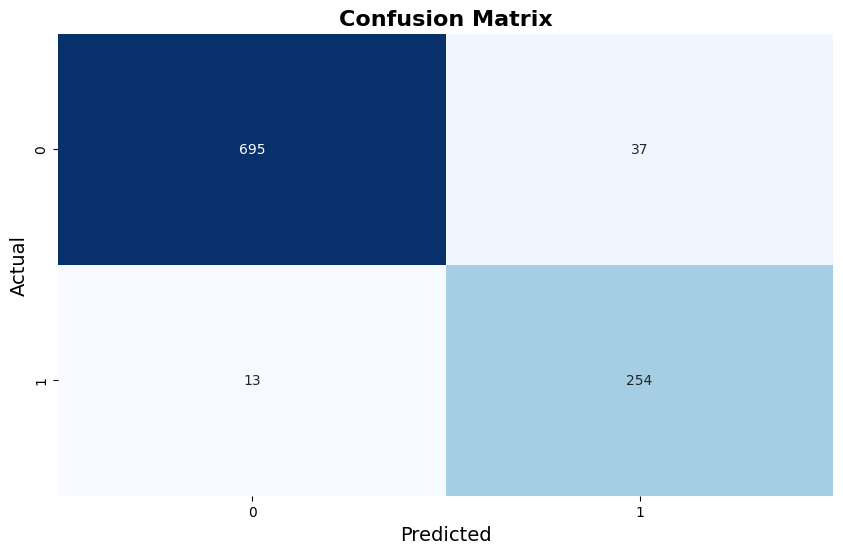

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', classification)

# Plotting confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
def test_model(text):
    transformed_text = transform_text(text)
    vectorized_text = tfid.transform([transformed_text]).toarray()
    prediction = model.predict(vectorized_text)
    return prediction[0]

# Example input
input_text = input("enter your sentence: ")
print('Prediction:', 'Spam' if test_model(input_text) == 1 else 'Not Spam')